<a href="https://colab.research.google.com/github/riyagoyal17/AI-Mafia-Machine-Learning/blob/main/loss_using_the_orig_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data/smalldata1.zip

Streaming output truncated to the last 5000 lines.
  inflating: smalldata1/tacos/101.png  
  inflating: smalldata1/tacos/102.png  
  inflating: smalldata1/tacos/103.png  
  inflating: smalldata1/tacos/104.png  
  inflating: smalldata1/tacos/105.png  
  inflating: smalldata1/tacos/106.png  
  inflating: smalldata1/tacos/107.png  
  inflating: smalldata1/tacos/108.png  
  inflating: smalldata1/tacos/109.png  
  inflating: smalldata1/tacos/11.png  
  inflating: smalldata1/tacos/110.png  
  inflating: smalldata1/tacos/111.png  
  inflating: smalldata1/tacos/112.png  
  inflating: smalldata1/tacos/113.png  
  inflating: smalldata1/tacos/114.png  
  inflating: smalldata1/tacos/115.png  
  inflating: smalldata1/tacos/116.png  
  inflating: smalldata1/tacos/117.png  
  inflating: smalldata1/tacos/118.png  
  inflating: smalldata1/tacos/119.png  
  inflating: smalldata1/tacos/12.png  
  inflating: smalldata1/tacos/120.png  
  inflating: smalldata1/tacos/121.png  
  inflating: smalldata1/tacos/1

In [3]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model,load_model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *


In [4]:
#DATA_DIR = "./data"
TRAIN_DIR = "/content/smalldata1"
#TEST_DIR = os.path.join(DATA_DIR, "test")
#print(os.listdir(TRAIN_DIR))
IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=20, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    #print(os.listdir(TRAIN_DIR))
    
    for c in os.listdir("/content/smalldata1"):
        #print(c)
        c_dir = os.path.join("/content/smalldata1",c)
        c_imgs = os.listdir(c_dir)
        #print(c_imgs," ")
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            #print(img_name_i)
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            #img_i = np.asarray(img_i).reshape(64,64)

           # print(img_i.size[0] , img_i.size[1])
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
  
    # Return train and test data as numpy arr
    return np.array(X_train)

In [5]:
# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()
X_train_orig = load_dataset_small()
print(X_train_orig.shape)
# Normalize image vectors.
X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
#print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

(2020, 64, 64, 3)
Number of training examples = 2020
X_train shape: (2020, 64, 64, 3)


In [6]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 4]
# S2: secret image2
input_S2 = X_train[(X_train.shape[0] // 4) : 2*(X_train.shape[0] // 4)]
# S3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]
#S4 : secret image4
#input_S4 = X_train[3*(X_train.shape[0] // 5) : 4*(X_train.shape[0] // 5)]





# C: cover image
input_C = X_train[3*(X_train.shape[0] // 4):]
print(input_C.shape)

(505, 64, 64, 3)


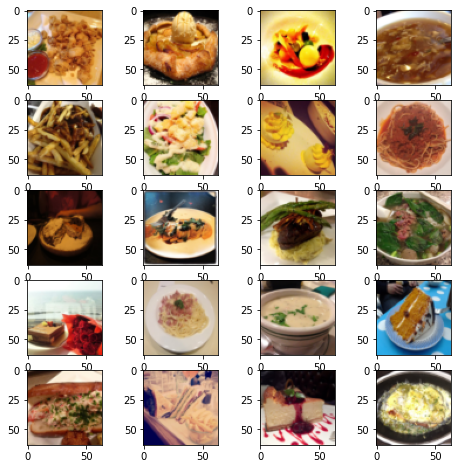

In [7]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [8]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred

    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print(y_true.shape, y_pred.shape)
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    #s4_loss = beta * K.sum(K.square(s4_true - s4_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss

In [9]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    print(input_size)
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    #input_S4 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    '''
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_4')(input_S4)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_4')(input_S4)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_4')(input_S4)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_4')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_4')(x)
    x4_1 = concatenate([x3, x4, x5])
    '''
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [10]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)
        
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)
'''        
def make_decoder4(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_4')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_4')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_4')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_4')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_4')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_4')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_4')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_4')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_4')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_4')(x)
    x = concatenate([x3, x4, x5])
    
    output_S4prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S4')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S4prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S4prime)
'''


'        \ndef make_decoder4(input_size, fixed=False):\n    \n    # Reveal network\n    reveal_input = Input(shape=(input_size))\n    \n    # Adding Gaussian noise with 0.01 standard deviation.\n    input_with_noise = GaussianNoise(0.01, name=\'output_C_noise2\')(reveal_input)\n    \n    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_3x3_4\')(input_with_noise)\n    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_4x4_4\')(input_with_noise)\n    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_5x5_4\')(input_with_noise)\n    x = concatenate([x3, x4, x5])\n    \n    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev1_3x3_4\')(x)\n    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev1_4x4_4\')(x)\n    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding=\'

In [11]:
# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    #input_S4 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss)
    decoder3.trainable = False
    ''' 
    decoder4 = make_decoder4(input_size)
    decoder4.compile(optimizer='adam', loss=rev_loss)
    decoder4.trainable = False
    '''
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)
    #output_S4prime = decoder4(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder1, decoder2, decoder3, autoencoder1

In [12]:
#in_shape = (1,64,64,3)
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])

(64, 64, 3)


In [13]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [14]:
BATCH_SIZE = 32
loss_history = []
m = input_S1.shape[0]
#autoencoder_model.load_weights('models/model_A21_999')
for epoch in range(0,400):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    #np.random.shuffle(input_S4)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    #rev_loss4 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        #batch_S4 = input_S4[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3,batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        #rev_loss4.append(reveal_model4.train_on_batch(x=C_prime,
         #                                     y=batch_S4))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        #K.set_value(reveal_model4.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f} '.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model_A21_3_hidding_images_with_original_model')
    
    loss_history.append(np.mean(ae_loss))
 

  0%|          | 0/16 [00:00<?, ?it/s]

(32, 64, 64, 12) (32, 64, 64, 12)
(32, 64, 64, 12) (32, 64, 64, 12)
(32, 64, 64, 3) (32, 64, 64, 3)
(32, 64, 64, 3) (32, 64, 64, 3)
(32, 64, 64, 3) (32, 64, 64, 3)
(32, 64, 64, 3) (32, 64, 64, 3)
(32, 64, 64, 3) (32, 64, 64, 3)
(32, 64, 64, 3) (32, 64, 64, 3)


Epoch 1 | Batch: 448 of 505. Loss AE  303164.25 | Loss Rev   87540.93 | Loss Rev2   68182.02 | Loss Rev3   74507.95 :  94%|█████████▍| 15/16 [01:11<00:02,  2.37s/it]

(25, 64, 64, 12) (25, 64, 64, 12)
(25, 64, 64, 3) (25, 64, 64, 3)
(25, 64, 64, 3) (25, 64, 64, 3)
(25, 64, 64, 3) (25, 64, 64, 3)


Epoch 1 | Batch: 480 of 505. Loss AE  293173.84 | Loss Rev   84716.30 | Loss Rev2   65685.59 | Loss Rev3   73425.12 : 100%|██████████| 16/16 [01:20<00:00,  5.04s/it]
Epoch 2 | Batch: 480 of 505. Loss AE  111944.14 | Loss Rev   28949.19 | Loss Rev2   31174.95 | Loss Rev3   30010.93 : 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]
Epoch 3 | Batch: 480 of 505. Loss AE   94380.79 | Loss Rev   24813.11 | Loss Rev2   25524.77 | Loss Rev3   25168.86 : 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]
Epoch 4 | Batch: 480 of 505. Loss AE   89797.48 | Loss Rev   23354.30 | Loss Rev2   24386.38 | Loss Rev3   24446.51 : 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]
Epoch 5 | Batch: 480 of 505. Loss AE   81251.28 | Loss Rev   22811.30 | Loss Rev2   20555.48 | Loss Rev3   21164.55 : 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]
Epoch 6 | Batch: 480 of 505. Loss AE   91404.63 | Loss Rev   26358.69 | Loss Rev2   31037.01 | Loss Rev3   17233.97 : 100%|██████████| 16/16 [00:33<00:00,  2.07s/it]
Epoc

In [21]:
autoencoder_model.load_weights('models/model_A21_3_hidding_images_with_original_model')
autoencoder_model.save('autoencoder_model_model_A21_3_hidding_images_with_original_modelll')

INFO:tensorflow:Assets written to: autoencoder_model_model_A21_3_hidding_images_with_original_modelll/assets


In [26]:
autoencoder_model = load_model('/content/autoencoder_model_model_A21_3_hidding_images_with_original_model.h5', compile = False)

In [27]:
ae_loss_history = autoencoder_model.history["ae_loss"]
rev_loss1_history = autoencoder_model.history["rev_loss1"]
rev_loss2_history = autoencoder_model.history["rev_loss2"]
rev_loss3_history = autoencoder_model.history["rev_loss3"]
rev_loss4_history = autoencoder_model.history["rev_loss4"]

TypeError: ignored

In [ ]:
autoencoder_model.save_weights('models/model_A21')

In [35]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12],

# Get absolute difference between the outputs and the expected values.
diff_S1, diff_S2, diff_S3, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_S3 - input_S3),np.abs(decoded_C - input_C)

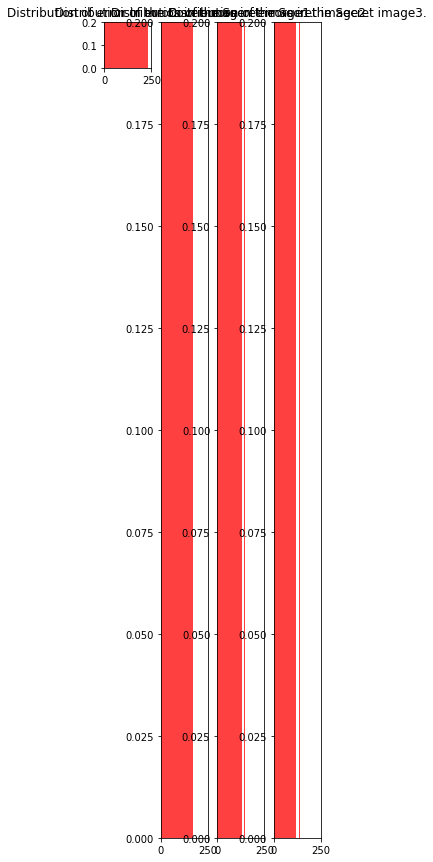

In [52]:
def pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel, see_S3pixel, see_Cpixel

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    #diff_S4flat = diff_S4.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 15))
    a=fig.add_subplot(15,15,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100,  alpha=0.75,facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,15,2)
    imgplot = plt.hist(255* diff_S1flat, 100,  alpha=0.75,facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,15,3)
    imgplot = plt.hist(255* diff_S2flat, 100, alpha=0.75,facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,15,4)
    imgplot = plt.hist(255* diff_S3flat, 100,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    '''
    a=fig.add_subplot(1,15,5)
    imgplot = plt.hist(255* diff_S4flat, 100,alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    '''
    plt.show()


pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

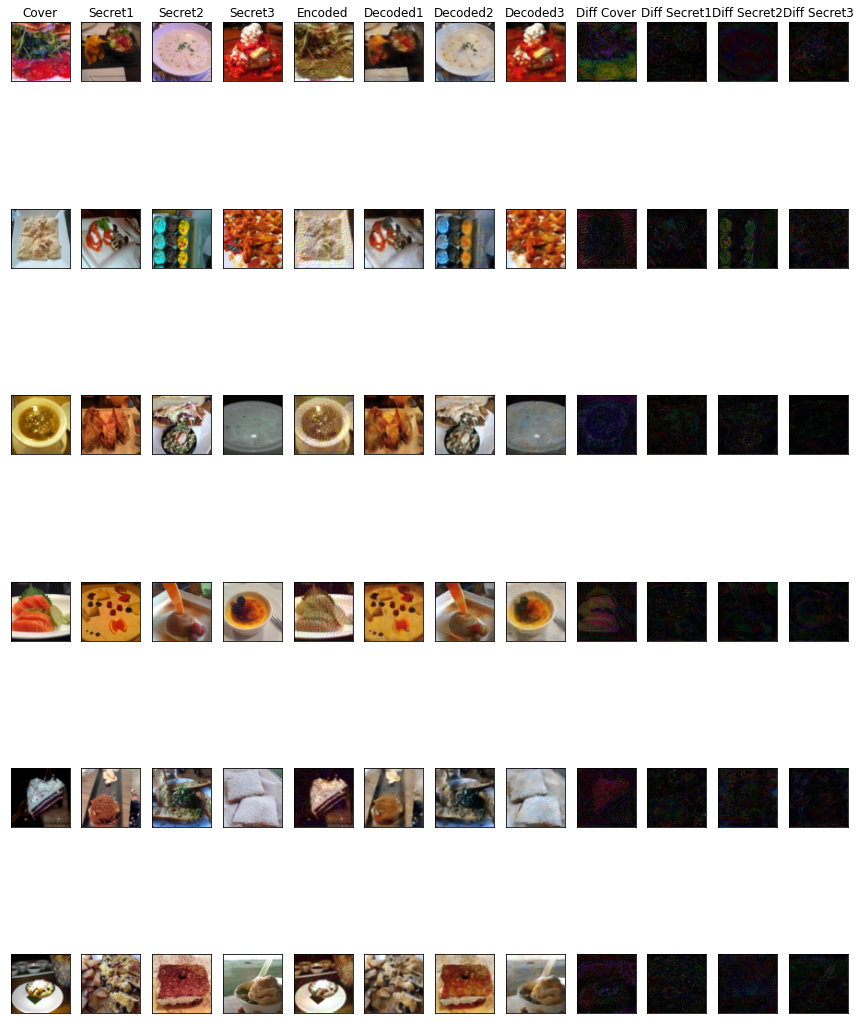

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [39]:

# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(15, 20))
rand_indx = [random.randint(0, 161) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')

    #show_image(input_S4[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Secret4')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

    #show_image(decoded_S4[idx], n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Decoded4')

    
    if SHOW_DIFF:
         show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
       
         show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

         show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

         show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

         
         #show_image(np.multiply(diff_S4[idx], ENHANCE), n, n_col, i * n_col + 15, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret4')

plt.show()
from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 

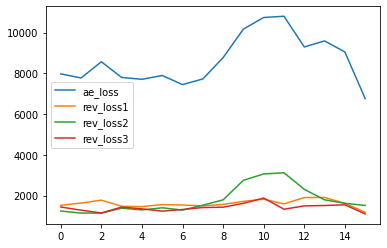

In [50]:
epochs = range(0,16)

plt.plot(ae_loss,label = 'ae_loss')
plt.plot(rev_loss1,label = 'rev_loss1')
plt.plot(rev_loss2,label = 'rev_loss2')
plt.plot(rev_loss3,label = 'rev_loss3')
#plt.plot(epochs,rev_loss4)
plt.legend()
plt.show()

In [44]:
print(ae_loss.count)

<built-in method count of list object at 0x7f2a097b5370>


In [51]:
from google.colab import files

files.download('ae_loss.txt')

FileNotFoundError: ignored

In [53]:
autoencoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
____________________________________________________________________________________________

In [54]:
print(ae_loss)

[7973.6884765625, 7772.8779296875, 8568.1923828125, 7797.09033203125, 7708.3515625, 7892.63525390625, 7447.984375, 7724.501953125, 8771.9169921875, 10172.46875, 10741.30859375, 10802.31640625, 9294.693359375, 9592.1171875, 9050.7529296875, 6759.767578125]


In [55]:
print(rev_loss1)

[1525.711669921875, 1633.2677001953125, 1776.709228515625, 1474.2794189453125, 1457.5240478515625, 1558.296142578125, 1536.341796875, 1496.298828125, 1567.1954345703125, 1717.2467041015625, 1821.4747314453125, 1593.268310546875, 1904.531982421875, 1909.3564453125, 1617.445068359375, 1180.999755859375]


In [56]:
print(rev_loss2)

[1242.6551513671875, 1140.54296875, 1139.692138671875, 1383.078369140625, 1295.6192626953125, 1401.6968994140625, 1288.4456787109375, 1528.824462890625, 1791.123046875, 2751.826171875, 3061.498291015625, 3119.623046875, 2306.417724609375, 1792.20263671875, 1621.9698486328125, 1518.141845703125]


In [57]:
print(rev_loss3)

[1439.4232177734375, 1283.2598876953125, 1147.375, 1435.85546875, 1348.162841796875, 1237.0606689453125, 1316.6302490234375, 1413.927734375, 1429.9334716796875, 1620.1915283203125, 1878.449462890625, 1329.99462890625, 1494.3997802734375, 1512.73046875, 1548.914306640625, 1100.2562255859375]


In [58]:
print(rev_loss)

<function rev_loss at 0x7f2ac0e21830>
